In [0]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, ActivityRegularization, BatchNormalization, Conv2D, AveragePooling2D, Flatten
from keras.layers import Input,Add,MaxPooling2D,LSTM,TimeDistributed
from keras.models  import Model
from keras import regularizers
from keras.optimizers import Adamax
import keras
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

janela = 25 #valor impar
size = int(janela/2) #tamanho a ser incrementado nas laterais


In [0]:
def load(X):
    data = X['prot']
    classes = X['class']
    positions = {'A':0,'C':1,'D':2,'E':3,'F':4,'G':5,'H':6,'I':7,'K':8,'L':9,'M':10,'N':11,
                 'P':12,'Q':13,'R':14,'S':15,'T':16,'V':17,'W':18,'Y':19}
    classes_converter = {'-': 0, 'E':1, 'H':2}
    res = []
    for i in range(len(data)):
        for j in range(len(data[i])):
            res.append(int(positions[data[i][j]])+1)
    for i in range(size):
        res.insert(0, 0)
        res.append(0)
    data =[]
    for i in range(len(X['prot'])):
        data.append(res[i:janela+i])
        data[i].append(classes_converter[classes[i]])
    columns = [[]]*(janela+1)
    for i in range(janela):
        columns[i] = "Element" + str(i)
    columns[janela] = 'Class'
    data = pd.DataFrame(data, columns = columns)
    return data

def load_data():
    proteins = pd.read_csv('cb513.csv',sep='\s*,\s*')
    res = load(proteins.iloc[0])
    for i in range(1,len(proteins)):
        aux = load(proteins.iloc[i])
        res = res.append(aux,ignore_index = True)
    print(res)
    return res

In [0]:
def buildScoringMatrix():
    """
    Building protein scoring matrix and creating a dictionary with the aminoacids and each of their corresponding
    rows in the matrix
    :return:
    """
    positions = {'A':0,'C':1,'D':2,'E':3,'F':4,'G':5,'H':6,'I':7,'K':8,'L':9,'M':10,'N':11,
                 'P':12,'Q':13,'R':14,'S':15,'T':16,'V':17,'W':18,'Y':19}
    res = ['A','C','D','E','F','G','H','I','K','L','M','N',
                 'P','Q','R','S','T','V','W','Y']
    M=[[4,   0, -1, -2,  0, -1, -2, -3, -1, -1,  1,  0, -2, -2, -1, -2, -1, -2, -2, -1],
       [-1, -2, -3 ,-3 ,-3 ,-3, -4, -4,  8, -3, -1, -1, -3, -2, -1, -2, -1, -2, -2, -1],
       [3,   2, -2 ,-2 ,-1 ,-1, -3, -3, -1, -1,  1,  3, -2, -1, -1, -2, -1, -2, -2, -1],
       [2,  -2,  1,  0,  2,  0,  3, -2, -2, -1,  0, -1,  0, -2, -2, -2, -2, -2, -3, -2],
       [0,  -1, -1, -2, -1, -1, -2, -3, -1, -1,  3,  4, -2,  0, -1, -2, -1, -1, -1, -1],
       [0,  -3,  3,  1,  4,  1, -1, -3, -3, -1, -2,  0, -1, -3, -2, -3, -3, -3, -3, -3],
       [0,  -1, -1, -2, -1, -1, -2, -3, -1, -1, -3,  4, -2,  0, -1, -2, -1, -1, -1, -1],
       [-1, -2, -3, -3, -3, -3, -4, -4,  8, -3, -1, -1, -3, -2, -2, -2, -1, -2, -2, -1],
       [3,   0, -2, -2, -1, -1, -2, -3, -1, -1,  3,  1, -2, -1, -1, -1, -1, -1, -1, -1],
       [1,  -1 ,-2 ,-2 ,-1 ,-1, -3, -3, -1, -1,  4,  3, -2,  0,  0, -1, -1, -1, -1, -1],
       [0,   6, -4, -4, -3 ,-3, -3, -3, -2, -3,  0, -2, -3, -1, -2, -2, -2, -3, -2, -2],
       [0,  -3 , 1,  4,  1 , 2,  0, -2, -3, -1, -2, -1, -1, -3, -2, -3, -2, -2, -4, -3],
       [2,   0 ,-2, -2, -1, -2, -3, -3, -1, -1,  4,  1, -2,  0,  0, -1,  0, -1, -1,  0],
       [-2, -1 ,-3 ,-4 ,-3, -3, -4, -4, -2, -4,  0, -1, -3,  3,  0, -1, -1, -2,  6,  1],
       [0 ,  6, -4, -4, -3, -3, -3, -3, -2, -3,  0, -2, -3, -1, -2, -2, -2, -3, -2, -2],
       [1 , -1 ,-2 ,-2, -1, -1, -3, -2, -1, -2,  1,  3, -2,  0,  4, -1,  0,  0, -1,  0],
       [0,  -2,  1, -1,  2,  0, -2, -3, -3, -1,  2,  3, -1, -1, -1, -2, -1, -2, -2, -1],
       [0,  -3,  3,  1,  4,  1, -1, -3, -3, -1, -2,  0, -1, -3, -2, -3, -3, -3, -3, -3],
       [0 , -1 ,-2, -2, -1, -1, -3, -3, -1, -2,  2,  3, -2,  0,  0, -1,  3,  1, -1,  0],
       [0,  -3,  3,  1,  4,  1, -1, -3, -3, -1, -2,  0, -1, -3, -2, -3, -3, -3, -3, -3],
       [3,   0, -2, -2, -1, -1, -3, -3, -1, -1,  3,  1, -2,  0,  0, -1, -1, -1, -1, -1]]
    M = np.array(M).transpose()
    M = M.reshape(-1,21,1)
    #M = pd.DataFrame(data=M,index=res)
    return M

def position_values_to_scores(data):
    """
    :param data: The data must already be treated by the load_data and the load(X) procedures
    the transformation is made only using the features
    :return: data with each position value replaced by its corespondent column in the scoring matrix
    """
    assert type(data) == np.ndarray
    assert data.shape[1] == janela
    zeros = np.zeros((21,1),dtype=np.int32).tolist()
    M = buildScoringMatrix()
    newData = []
    for i,res in enumerate(data):
        newData.append([])
        for j,amin in enumerate(res):
            if amin != 0:
                newData[i].append(M[amin-1,:].tolist())
            else:
                newData[i].append(zeros)

    return np.array(newData)

### Model's Implementation

In [0]:
def conv2DModel(input_shape,n_classes):
  model = Sequential()
  reg = 0.01
  model.add(Conv2D(32,(3),input_shape=input_shape,use_bias=True,
                   kernel_regularizer=regularizers.l2(reg),activation='relu'))
  model.add(Conv2D(64,(3),use_bias=True,
                   kernel_regularizer=regularizers.l2(reg),activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(64,activation='relu',use_bias=True
                  ,name="first_fc_layer",kernel_regularizer=regularizers.l2(reg)))
  model.add(Dense(128,activation='tanh',use_bias=True
                  ,name="second_fc_layer",kernel_regularizer=regularizers.l2(reg)))
  model.add(Dense(128,activation='tanh',use_bias=True
                  ,name="third_fc_layer",kernel_regularizer=regularizers.l2(reg)))
  model.add(Dense(64,activation='relu',use_bias=True
                  ,name="fourch_fc_layer",kernel_regularizer=regularizers.l2(reg)))
  model.add(Dense(n_classes,activation='softmax',use_bias=True
                        ,kernel_regularizer=regularizers.l2(reg)))
  model.summary()
  return model

In [0]:
def conv2DResnet(input_shape, n_classes):
    reg = 0.01

    # First Skip Layer 64
    X_input = Input(input_shape)
    X_skip = Conv2D(32, (3),use_bias=True,
                    kernel_regularizer=regularizers.l2(reg), activation='relu')(X_input)
    X = Conv2D(32, (3), use_bias=True,padding='same',
               kernel_regularizer=regularizers.l2(reg),activation='relu')(X_skip)
    X = Add()([X_skip, X])
    X = BatchNormalization()(X)

    # Third Skip Layer 512
    X_skip = Conv2D(64, (3), use_bias=True,
                    kernel_regularizer=regularizers.l2(reg), activation='relu')(X)
    X = Conv2D(64, (3), padding='same',use_bias=True, 
               kernel_regularizer=regularizers.l2(reg),activation='relu')(X_skip)
    X = Add()([X_skip, X])
    X = BatchNormalization()(X)
    X = MaxPooling2D(2)(X)

    # Fully Connected part

    X = Flatten()(X)
    X = Dense(64, activation='relu', name="first_fc_layer", use_bias=True,
              kernel_regularizer=regularizers.l2(reg))(X)
    X = Dense(128, activation='relu', name="second_fc_layer", use_bias=True,
              kernel_regularizer=regularizers.l2(reg))(X)
    X = Dense(64, activation='relu', name="third_fc_layer", use_bias=True,
              kernel_regularizer=regularizers.l2(reg))(X)
    X = Dense(n_classes, activation='softmax', name="class", use_bias=True
              , kernel_regularizer=regularizers.l2(reg))(X)

    model = Model(inputs=X_input, outputs=X, name="Conv1DResnet")
    model.summary()
    return model

### Model's Training and validation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


       Element0  Element1  Element2  ...  Element23  Element24  Class
0             0         0         0  ...         20         11      0
1             0         0         0  ...         11          5      0
2             0         0         0  ...          5         19      1
3             0         0         0  ...         19          1      1
4             0         0         0  ...          1         13      1
5             0         0         0  ...         13         12      1
6             0         0         0  ...         12          2      1
7             0         0         0  ...          2         12      1
8             0         0         0  ...         12          4      1
9             0         0         0  ...          4         12      1
10            0         0        16  ...         12          8      1
11            0        16        14  ...          8         18      1
12           16        14         8  ...         18         11      1
13           14     

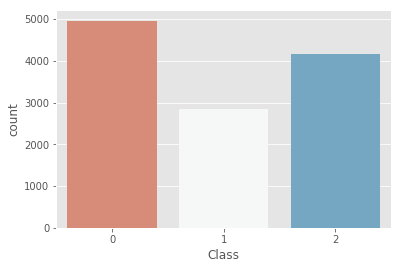

In [0]:
data = load_data()

coil = data.loc[data['Class'] == 0]
fita = data.loc[data['Class'] == 1]
helice = data.loc[data['Class'] == 2]

print(len(coil)/len(data))
print(len(fita)/len(data))
print(len(helice)/len(data))
sns.countplot(x='Class', data=data, palette='RdBu')

X = data.drop(['Class'], axis=1)
y = data['Class']

In [0]:
X = np.asarray(X)

X = position_values_to_scores(X)


#standardizing data ====================================
sample_height = X.shape[1]
sample_width = X.shape[2]
last_column = 1

X  = X.reshape(-1,X.shape[1]*X.shape[2]*X.shape[3])
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X = X.reshape(-1,sample_height,sample_width,last_column)
#=======================================================


X,y = sklearn.utils.shuffle([X,y])

print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

(11973, 25, 21, 1)
(11973,)


In [0]:
def evaluate_model(model,hist,X_test,y_test,batch_size,epochs):
    predictions = model.predict(X_test, batch_size=batch_size)
    value = classification_report(y_test.argmax(axis=1),
                                  predictions.argmax(axis=1))
    print(value)

    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    # plt.xscale('log')
    # plt.yscale('log')
    plt.ylim((0, 1))
    plt.plot(np.arange(0, epochs), hist.history["acc"], label="train_acc")
    plt.plot(np.arange(0, epochs), hist.history["val_acc"], label="val_acc")
    plt.title("Training and validation Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

Data shape (25, 21, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 25, 21, 1)    0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 23, 19, 32)   320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 23, 19, 32)   9248        conv2d_65[0][0]                  
__________________________________________________________________________________________________
add_21 (Add)                    (None, 23, 19, 32)   0           conv2d_65[0][0]                  
                                                                 conv2d_66[0][0]      

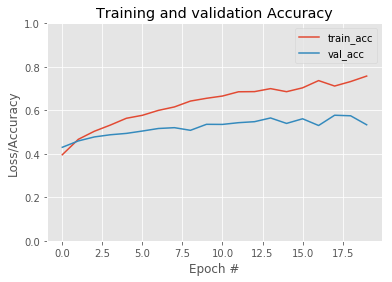

In [0]:
epochs = 100
batch_size=512
input_shape = X.shape[1:]
print("Data shape",input_shape)
#model = conv2DModel(input_shape,3)
model = conv2DResnet(input_shape,3)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=.01,momentum=.5), 
              metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

evaluate_model(model, hist, X_test, y_test, batch_size, epochs)

In [0]:
predictions = model.predict(X_test)
p = [ np.argmax(p)  for p in predictions]
df = pd.DataFrame(p,index=['class'])



ValueError: ignored

In [0]:
from keras import backend as k
k.clear_session()

In [0]:
from sklearn.ensemble import RandomForestClassifier

X = data.drop(['Class'], axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

print(confusion_matrix(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test)))
